# Divergence Analysis 

### Imports and paths

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import amplpy
from pathlib import Path

from util.return_up_outliers_func import *

In [7]:
# Paths
path_data_network = Path('data_network') 
path_data_DA = Path('results')
path_current = Path('.')

run_ampl_files = False

In [8]:
if run_ampl_files :
    ampl = amplpy.AMPL()
    ampl.read_data('DA_runner.run')
    ampl.close()

In [10]:
# Import data from network
df_branches = pd.read_table(path_data_network / 'ampl_network_branches.txt', sep=" ", header=1).drop(columns=["#\"variant\""])
df_buses = pd.read_table(path_data_network / 'ampl_network_buses.txt', sep=" ", header=1).drop(columns=["#\"variant\""])

# Import values from divergence analysis results
df_var_Vtheta = pd.read_csv(path_data_DA / "Vtheta_var.csv", sep=";", header=1)
df_penal_s = pd.read_csv(path_data_DA / "s1_penal.csv", sep=";", header=1)
df_penal_sigma = pd.read_csv(path_data_DA / "sigma_penal_dbb.csv", sep=";", header=1)

### Calculation of sets and params for the rest of the analysis

##### About V and theta values

<Axes: >

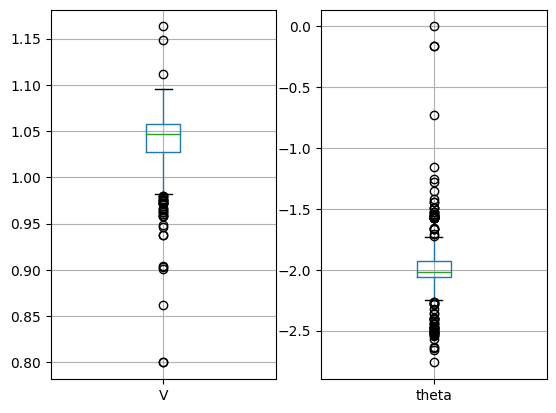

In [11]:
fig, axes = plt.subplots(1,2)
df_var_Vtheta.boxplot(column=['V'], ax=axes.flatten()[0])
df_var_Vtheta.boxplot(column=['theta'], ax=axes.flatten()[1]) 

In [12]:
V_min, V_max, theta_min, theta_max = 0.8, 1.2, -3.141592, 3.141592
count_V_min, count_V_max, count_theta_min, count_theta_max = 0, 0, 0, 0
for index, row in df_var_Vtheta.iterrows():
    if row['V'] <= V_min:
        count_V_min += 1
        print("Bus n°" + str(row['bus']) + ", with id " + row['id'] + ", min value of voltage reached.")
    elif row['V'] >= V_max:
        count_V_max += 1
        print("Bus n°" + str(row['bus']) + ", with id " + row['id'] + ", max value of voltage reached.")
    if row['theta'] <= theta_min:
        count_theta_min += 1
        print("Bus n°" + str(row['bus']) + ", with id " + row['id'] + ", min value of theta reached.")
    elif row['theta'] >= theta_max:
        count_theta_max += 1
        print("Bus n°" + str(row['bus']) + ", with id " + row['id'] + ", max value of theta reached.")

print("Total number of buses with min voltage value :", count_V_min)
print("Total number of buses with max voltage value :", count_V_max)
print("Total number of buses with min theta value :", count_theta_min)
print("Total number of buses with max theta value :", count_theta_max)

Bus n°35, with id '.MAASP7_0', min value of voltage reached.
Total number of buses with min voltage value : 1
Total number of buses with max voltage value : 0
Total number of buses with min theta value : 0
Total number of buses with max theta value : 0


##### About s penalization

<Axes: >

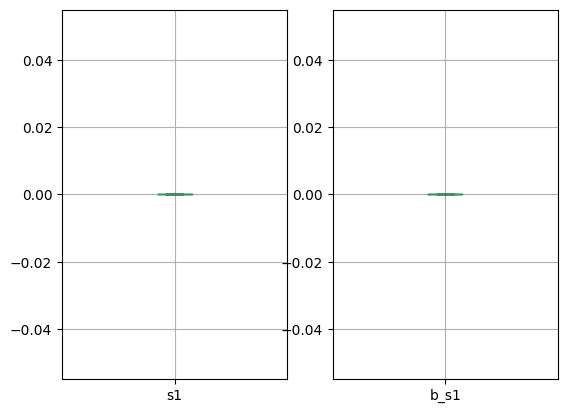

In [13]:
fig, axes = plt.subplots(1,2)
df_penal_s.drop('id',axis=1).abs().boxplot(column=['s1'], ax=axes.flatten()[0])
df_penal_s.drop('id',axis=1).abs().boxplot(column=['b_s1'], ax=axes.flatten()[1])

About sigma penalization

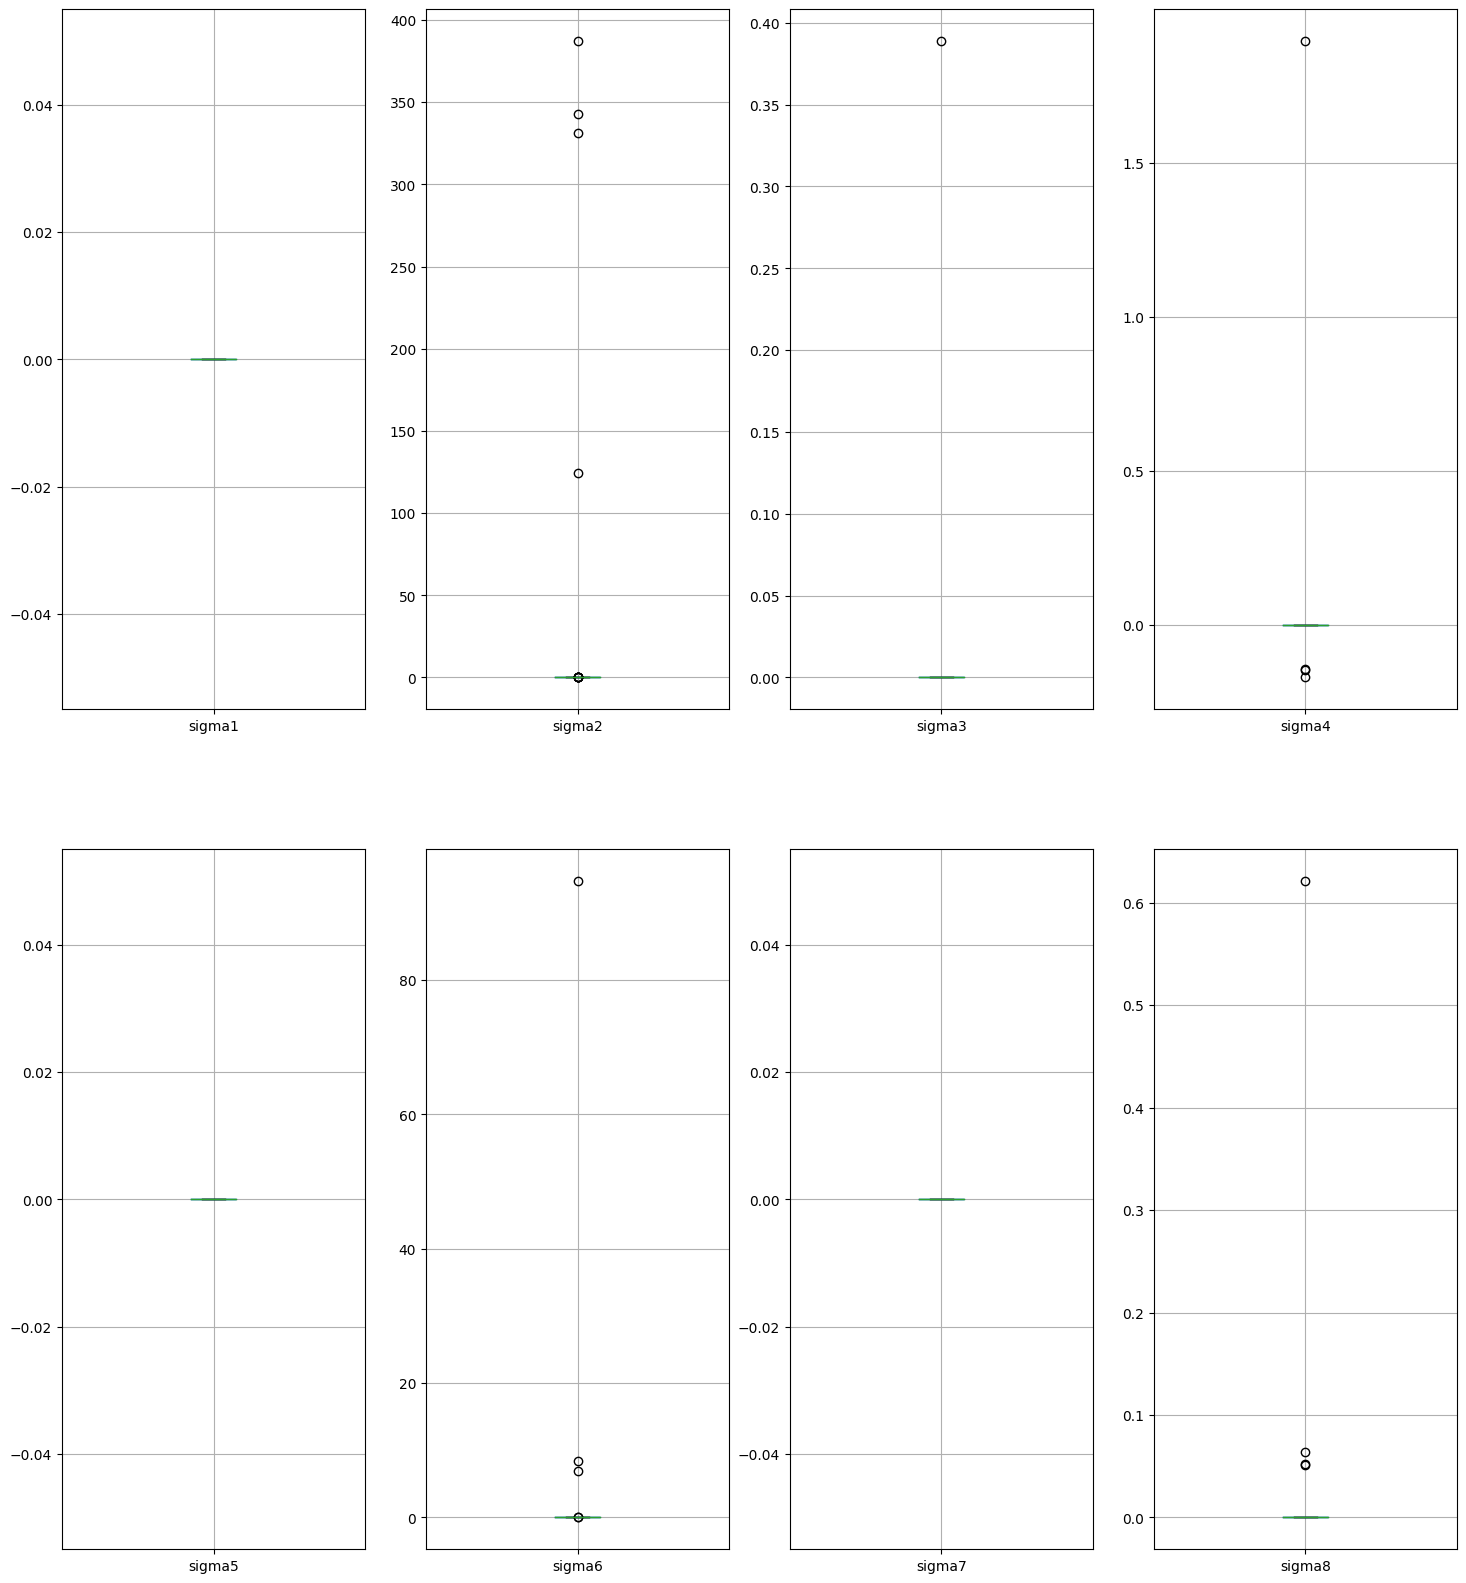

In [14]:
fig, axes = plt.subplots(2,4, figsize=(18,20))
for i in range(1,9):
    df_penal_sigma.boxplot(column=['sigma'+str(i)], ax=axes.flatten()[i-1])

<Axes: >

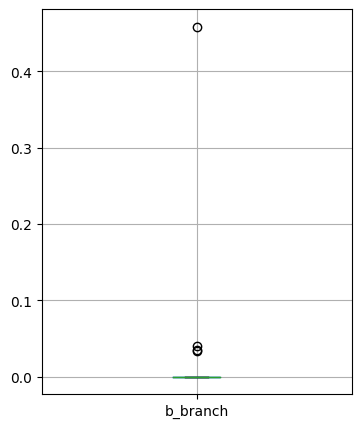

In [15]:
fig, axes = plt.subplots(1,1, figsize=(4,5))
df_penal_sigma.boxplot(column=['b_branch'])
#print(df_penal_sigma[df_penal_sigma['b_branch']==1])

### Print info about important penalization

In [9]:
def print_important_branch_penal_Zscore(var_penal, df_penal, df_data, threshold, elem_penal, penal_bus=None):
    """ Print some information on the penalization of df['elem_penal'] values. """

    print("# ABOUT {elem_penal} PENALIZATION".format(elem_penal=elem_penal.upper()))
    for index, element in return_up_outliers_Zscore(df_penal[var_penal].abs(), threshold).items():
        data_index = df_penal['branch'].get(index) - 1
        gap = 100 * element / (df_data[elem_penal].get(data_index)+0.0000001)
        string = "Branch/transfo n°"
        
        if 'num' in df_data.keys():
            string += str(df_data['num'].get(data_index))
        elif 'branch' in df_data.keys():
            string += str(df_data['branch'].get(data_index))

        bus1, bus2 = df_data['bus1'].get(data_index), df_data['bus2'].get(data_index)

        if penal_bus != None:
            penal_bus.add(bus1)
            penal_bus.add(bus2)

        string += ", between bus " + str(bus1) + " and " + str(bus2)
        string += " with id \"" + df_data['id'].get(data_index).strip("''")
        string += "\", important value of penalization : " + str(element) + "   (gap of " + "{:.2f}".format(gap) + "%)"
        print(string)
    print()

def print_important_bus_penal_Zscore(var_penal, df_penal, df_data, threshold, elem_penal, penal_bus=None):
    """ Print some information on the penalization of df['elem_penal'] values. """

    print("# ABOUT {elem_penal} PENALIZATION".format(elem_penal=elem_penal.upper()))
    for index, element in return_up_outliers_Zscore(df_penal[var_penal].abs(), threshold).items():
        gap = 100 * element / (df_data[elem_penal].get(index)+0.0000001)
        string = "Bus n°" + str(df_penal['busPV'].get(index))
        
        if penal_bus != None:
            penal_bus.add(df_penal['busPV'].get(index))

        string += " with id \"" + df_data['id'].get(index).strip("''")
        string += "\", important value of penalization : " + str(element) + "   (gap of " + "{:.2f}".format(gap) + "%)"
        print(string)
    print()

def print_important_branch_penal_IQR(var_penal, df_penal, df_data, threshold, elem_penal):
    """ Print some information on the penalization of df['elem_penal'] values. """

    print("# ABOUT {elem_penal} PENALIZATION".format(elem_penal=elem_penal.upper()))
    for index, element in return_up_outliers_IQR(df_penal[var_penal].abs(), threshold).items():

        data_index = df_penal['branch'].get(index) - 1 # -1 FIXME ????
        gap = 100 * element / (df_data[elem_penal].get(data_index)+0.0000001)
        string = "Branch/transfo n°"
        
        if 'num' in df_data.keys():
            string += str(df_data['num'].get(data_index))

        bus1, bus2 = df_data['bus1'].get(data_index), df_data['bus2'].get(data_index)
        string += ", between bus " + str(bus1) + " and " + str(bus2)
        string += " with id \"" + df_data['id'].get(data_index).strip("''")
        string += "\", important value of penalization : " + str(element) + "   (gap of " + "{:.2f}".format(gap) + "%)"
        print(string)
    print()

def print_important_bus_penal_IQR(var_penal, df_penal, df_data, threshold, elem_penal):
    """ Print some information on the penalization of df['elem_penal'] values. """

    print("# ABOUT {elem_penal} PENALIZATION".format(elem_penal=elem_penal.upper()))
    for index, element in return_up_outliers_IQR(df_penal[var_penal].abs(), threshold).items():
        gap = 100 * element / (df_data[elem_penal].get(index)+0.0000001)
        string = "Bus n°" + str(df_penal['busPV'].get(index))
        string += " with id \"" + df_data['id'].get(index).strip("''")
        string += "\", important value of penalization : " + str(element) + "   (gap of " + "{:.2f}".format(gap) + "%)"
        print(string)
    print()

In [124]:
#threshold = 0.1
#print_important_bus_penal_IQR('s1', df_penal_s, df_penal_s, threshold, 'targetV')
#print_important_branch_penal_IQR("sigma1", df_penal_sigma, df_branches, threshold, 'cst ratio (pu)')
#print_important_branch_penal_IQR("sigma2", df_penal_sigma, df_penal_sigma, threshold, 'admittance')
#print_important_branch_penal_IQR("sigma3", df_penal_sigma, df_penal_sigma, threshold, 'dephor')
#print_important_branch_penal_IQR("sigma4", df_penal_sigma, df_penal_sigma, threshold, 'angper')
#print_important_branch_penal_IQR("sigma5", df_penal_sigma, df_branches, threshold,'g1 (pu)')
#print_important_branch_penal_IQR("sigma6", df_penal_sigma, df_branches, threshold,'b1 (pu)')
#print_important_branch_penal_IQR("sigma7", df_penal_sigma, df_branches, threshold,'g2 (pu)')
#sprint_important_branch_penal_IQR("sigma8", df_penal_sigma, df_branches, threshold,'b2 (pu)')


In [10]:
threshold = 3
penal_buses = set()
print_important_bus_penal_Zscore('s1', df_penal_s, df_penal_s, threshold, 'targetV', penal_buses)
print_important_branch_penal_Zscore("sigma1", df_penal_sigma, df_branches, threshold, 'cst ratio (pu)', penal_buses)
print_important_branch_penal_Zscore("sigma2", df_penal_sigma, df_penal_sigma, threshold, 'admittance', penal_buses)
print_important_branch_penal_Zscore("sigma3", df_penal_sigma, df_penal_sigma, threshold, 'dephor', penal_buses)
print_important_branch_penal_Zscore("sigma4", df_penal_sigma, df_penal_sigma, threshold, 'angper', penal_buses)
print_important_branch_penal_Zscore("sigma5", df_penal_sigma, df_branches, threshold,'g1 (pu)', penal_buses)
print_important_branch_penal_Zscore("sigma6", df_penal_sigma, df_branches, threshold,'b1 (pu)', penal_buses)
print_important_branch_penal_Zscore("sigma7", df_penal_sigma, df_branches, threshold,'g2 (pu)', penal_buses)
print_important_branch_penal_Zscore("sigma8", df_penal_sigma, df_branches, threshold,'b2 (pu)', penal_buses)


# ABOUT TARGETV PENALIZATION

# ABOUT CST RATIO (PU) PENALIZATION
Branch/transfo n°611, between bus 246 and 243 with id "12ad59a3-de56-49b5-9585-608969daa896", important value of penalization : 0.14048   (gap of 15.53%)
Branch/transfo n°695, between bus 381 and 378 with id "4baa0f35-106e-435a-bea1-d7ed22be49e7", important value of penalization : 0.11867   (gap of 13.12%)
Branch/transfo n°824, between bus 580 and 579 with id "58f70161-f3f2-4142-b3e7-83ec67d57ea8", important value of penalization : 0.13868   (gap of 15.44%)

# ABOUT ADMITTANCE PENALIZATION
Branch/transfo n°623, between bus 264 and 263 with id "875dd789-bc4a-46ab-996a-44ad90bd3eba", important value of penalization : 71.64108   (gap of 189.68%)
Branch/transfo n°672, between bus 346 and 350 with id "78d8d179-2a91-4566-ad5f-f9778990bccb", important value of penalization : 121.39715   (gap of 773.80%)
Branch/transfo n°673, between bus 346 and 349 with id "52619407-026c-453c-ac72-c79e91485f1d", important value of penalization 

### Exportation of buses with important penalization

In [126]:
with open(path_data_DA / 'bus_important_penal.txt', 'w') as file:
    file.write('# Bus with important penal in divergence analysis\n')
    file.write('# "penal_bus" "bus"\n')
    
    count = 1
    for bus in penal_buses:
        string = "{i} {bus}\n".format(i=count,bus=bus)
        file.write(string)
        count += 1


# Analysis of refined divergence analysis

In [127]:
ampl = amplpy.AMPL()
ampl.read_data('test.run')
ampl.close()





















*** Start of file test.run : Mon Apr 17 17:54:54 2023

*** Reading algorithmic controls and parameters in file
PARAM_ALGO_VALUES [*] :=
;

Parameter: threshold to decide wether an active or reactive power value is zero Pnull:=0.01 (MW or Mvar or MVA)
Parameter: threshold to detect zero impedance branch Znull:=0.0001 pu
Parameter: for consistency checks of minimum nominal voltages epsilon_nominal_voltage:= 1 kV
Parameter: for consistency checks of voltage bounds eps<=Vmin<Vmax<=2-eps, epsilon_min_voltage:= 0.5 pu
Parameter: maximum for generating units parameters Pmin Pmax Qmin Qmax = 9000 MW or Mvar
Parameter: defaultPmax = 1000 MW
Parameter: defaultPmin = 0 MW
Parameter: defaultQmaxPmaxRatio = 0.3 Mvar/MW
Parameter: defaultQmin = -300 Mvar
Parameter: defaultQmax = 300 Mvar
Parameter: minimalQPrange = 1 MW or Mvar

*** Connexity computation
# CCcomp solve: start (Mon Apr 17 17:54:54 2023)

Artelys Knitro 13.2.0: ##### This license is only intended for use by Artelys

In [128]:
# Import values from divergence analysis results
df_var_Vtheta_R = pd.read_csv(path_data_DA / "REFINED_values_Vtheta.csv", sep=";")
df_penal_s_R = pd.read_csv(path_data_DA / "REFINED_values_s.csv", sep=";")
df_penal_sigma_R = pd.read_csv(path_data_DA / "REFINED_values_sigma.csv", sep=";")

In [129]:
threshold = 1
print_important_bus_penal_Zscore('s1', df_penal_s_R, df_penal_s_R, threshold, 'targetV')
print_important_branch_penal_Zscore("sigma1", df_penal_sigma_R, df_branches, threshold, 'cst ratio (pu)')
print_important_branch_penal_Zscore("sigma2", df_penal_sigma_R, df_penal_sigma_R, threshold, 'admittance')
print_important_branch_penal_Zscore("sigma3", df_penal_sigma_R, df_penal_sigma_R, threshold, 'dephor')
print_important_branch_penal_Zscore("sigma4", df_penal_sigma_R, df_penal_sigma_R, threshold, 'angper')
print_important_branch_penal_Zscore("sigma5", df_penal_sigma_R, df_branches, threshold,'g1 (pu)')
print_important_branch_penal_Zscore("sigma6", df_penal_sigma_R, df_branches, threshold,'b1 (pu)')
print_important_branch_penal_Zscore("sigma7", df_penal_sigma_R, df_branches, threshold,'g2 (pu)')
print_important_branch_penal_Zscore("sigma8", df_penal_sigma_R, df_branches, threshold,'b2 (pu)')

# ABOUT TARGETV PENALIZATION

# ABOUT CST RATIO (PU) PENALIZATION

# ABOUT ADMITTANCE PENALIZATION

# ABOUT DEPHOR PENALIZATION

# ABOUT ANGPER PENALIZATION

# ABOUT G1 (PU) PENALIZATION
Branch/transfo n°64, between bus 35 and 57 with id ".MAASL71.TDVA", important value of penalization : 218.708   (gap of 218708000000.00%)

# ABOUT B1 (PU) PENALIZATION

# ABOUT G2 (PU) PENALIZATION

# ABOUT B2 (PU) PENALIZATION

